For this experiment, look at how different models compare on the branching simulation w/ split space: y = fs(x1) + \sum_{k=1}^2 I(c=k) fk(x2). Although mixture isn't working, still want to see if split space helps. Settings are:
1. GPLVM, Q=2
2. GPLVM, Q=2, kernel is a sum of 2 kernels, one operate on x1 and the other on x2 (deal with split space)
3. S-GPLVM, Qs=Qp=1, K=1
4. S-GPLVM, Qs=Qp=1, K=2 (from the result of experiment on different pi's, this should be the same as 3.
5. S-GPLVM, Qp=2, K=2 (no shared space)

All models are optimized w/ natgrad + adam, Z's are learned and initialized the same way across models. M = 20.

Result
* Split space did not result in higher ELBO
* GPLVM always has higher ELBO, as is expected since ELBO for S-GPLVM is a lower bound of the ELBO of GPLVM
* None of the split space methods recover the right kernel lengthscales

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gpflow
import pandas as pd

from gpflow import set_trainable
from sklearn.decomposition import PCA

from utils import *

In [3]:
np.random.seed(1)

num_data = 200
dim = 5

xmin = 0
xmax = 10
break_pt = 3
k1 = 0.0
k21 = 0.3
k22 = -0.3
c1 = 0
sigma = 0.75
noise = 0.0
lengthscales = [0.2, 5, 1]

x = np.linspace(xmin, xmax, int(num_data/2), dtype=default_float())
X = branch_simulation(x, break_pt, k1, k21, k22, c1, sigma)
labels = np.repeat([0, 1], int(num_data)/2)
labels_dummy = pd.get_dummies(labels).values
Y = gen_obs(X, True, labels, dim, lengthscales, noise)

Text(0, 0.5, 'y2')

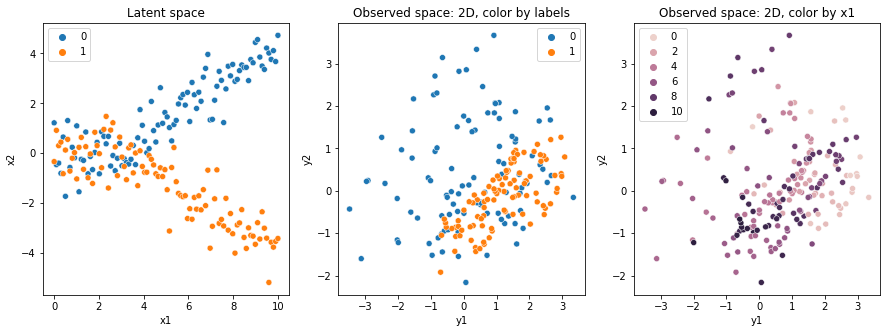

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, ax=axs[0])
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=labels, ax=axs[1])
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=X[:, 0], ax=axs[2])

axs[0].set_title('Latent space')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')

axs[1].set_title('Observed space: 2D, color by labels')
axs[1].set_xlabel('y1')
axs[1].set_ylabel('y2')

axs[2].set_title('Observed space: 2D, color by x1')
axs[2].set_xlabel('y1')
axs[2].set_ylabel('y2')

In [10]:
# fix inducing inputs initialization

np.random.seed(1)
M = 20
X_pca = PCA(n_components=2).fit_transform(Y)
Zp = np.random.permutation(X_pca[:, :1])[:M]
Zs = np.random.permutation(X_pca[:, :1])[:M]
Z = np.random.permutation(X_pca)[:M]

In [19]:
# gplvm, Q = 2
m1 = init_gplvm(
    Y=Y,
    latent_dim=2,
    kernel=gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
    inducing_variable=Z
)

In [23]:
# gplvm, Q = 2, split latent space with 2 kernels
m2 = init_gplvm(
    Y=Y,
    latent_dim=2,
    kernel=gpflow.kernels.SquaredExponential(lengthscales=[1.0], active_dims=[0]) + \
        gpflow.kernels.SquaredExponential(lengthscales=[1.0], active_dims=[1]),
    inducing_variable=np.concatenate([Zp, Zs], axis=1)
)

In [26]:
# split-gplvm, Qs=Qp=1, K=1
m3 = init_split_gplvm(
    Y=Y,
    split_space=True,
    K=1,
    Qp=1,
    Qs=1,
    Zp=Zp,
    Zs=Zs
)

# split-gplvm, Qs=Qp=1, K=2
m4 = init_split_gplvm(
    Y=Y,
    split_space=True,
    K=2,
    Qp=1,
    Qs=1,
    Zp=Zp,
    Zs=Zs
)

# split-gplvm, Qp=2, K=2
m5 = init_split_gplvm(
    Y=Y,
    split_space=False,
    K=2,
    Qp=2,
    Zp=Z
)

In [20]:
%%time
elbo1 = train_scipy(m1)

step 0 elbo: -2185.904652695237
step 1 elbo: -2070.6386596674756
step 2 elbo: -1923.2947026949141
step 3 elbo: -1746.609711841171
step 4 elbo: -1735.8899573285833
step 5 elbo: -1717.8132261946716
step 6 elbo: -1692.3956281199698
step 7 elbo: -1679.5212071511978
step 8 elbo: -1673.080114560765
step 9 elbo: -1664.131959238901
step 10 elbo: -1658.9728823678438
step 11 elbo: -1656.0925774620105
step 12 elbo: -1651.622537569951
step 13 elbo: -1645.0556771932265
step 14 elbo: -1640.8197119389297
step 15 elbo: -1636.3540146242954
step 16 elbo: -1631.0900161938168
step 17 elbo: -1629.060374566252
step 18 elbo: -1626.3014293749252
step 19 elbo: -1623.261848166458
step 20 elbo: -1621.8956954473797
step 21 elbo: -1620.3104441339985
step 22 elbo: -1618.4053712708064
step 23 elbo: -1617.0011171113674
step 24 elbo: -1615.8414824007282
step 25 elbo: -1614.8683269142537
step 26 elbo: -1613.9858053070398
step 27 elbo: -1613.273447229347
step 28 elbo: -1612.586383043944
step 29 elbo: -1612.08688326513
s

step 241 elbo: -1549.224101387405
step 242 elbo: -1549.222965015697
step 243 elbo: -1549.222002464253
step 244 elbo: -1549.2208813512748
step 245 elbo: -1549.2196028261717
step 246 elbo: -1549.2180576869287
step 247 elbo: -1549.2164580562958
step 248 elbo: -1549.2147655234317
step 249 elbo: -1549.2130345341338
step 250 elbo: -1549.2115318198914
step 251 elbo: -1549.210203957152
step 252 elbo: -1549.2089482960964
step 253 elbo: -1549.2075325480548
step 254 elbo: -1549.2061716458502
step 255 elbo: -1549.2046369640925
step 256 elbo: -1549.2031631059099
step 257 elbo: -1549.2016021429738
step 258 elbo: -1549.2001388001158
step 259 elbo: -1549.1989573353733
step 260 elbo: -1549.1978648943214
step 261 elbo: -1549.196568215878
step 262 elbo: -1549.1950376239129
step 263 elbo: -1549.193542942351
step 264 elbo: -1549.1919019335976
step 265 elbo: -1549.1904736258243
step 266 elbo: -1549.1891144313345
step 267 elbo: -1549.1878066253223
step 268 elbo: -1549.1863814342764
step 269 elbo: -1549.18490

step 480 elbo: -1548.1993689588016
step 481 elbo: -1548.1993688595576
step 482 elbo: -1548.1993687191277
step 483 elbo: -1548.1993685597422
step 484 elbo: -1548.1993683364244
step 485 elbo: -1548.1993680531564
step 486 elbo: -1548.1993677179753
step 487 elbo: -1548.1993673314705
step 488 elbo: -1548.1993669767403
step 489 elbo: -1548.1993665412774
step 490 elbo: -1548.199366007554
step 491 elbo: -1548.1993654653327
step 492 elbo: -1548.199364845282
step 493 elbo: -1548.1993643914434
step 494 elbo: -1548.1993638901731
step 495 elbo: -1548.1993633980055
step 496 elbo: -1548.1993632292015
step 497 elbo: -1548.1993629697686
step 498 elbo: -1548.1993626810058
step 499 elbo: -1548.1993625004777
step 500 elbo: -1548.199362336588
step 501 elbo: -1548.199362209671
step 502 elbo: -1548.1993621146767
step 503 elbo: -1548.199362062403
step 504 elbo: -1548.1993620201752
step 505 elbo: -1548.1993619729014
step 506 elbo: -1548.1993619449088
step 507 elbo: -1548.1993619242223
step 508 elbo: -1548.1993

In [25]:
%%time
elbo2 = train_scipy(m2)

step 0 elbo: -2044.2486669570844
step 1 elbo: -2020.719690789731
step 2 elbo: -1977.2567127404834
step 3 elbo: -1901.493545376133
step 4 elbo: -1782.7991923465493
step 5 elbo: -1747.7390636604591
step 6 elbo: -1712.2942231605837
step 7 elbo: -1699.0353875117614
step 8 elbo: -1692.3147791721003
step 9 elbo: -1685.2608898499645
step 10 elbo: -1676.8045568535856
step 11 elbo: -1671.17380313102
step 12 elbo: -1667.3372229101494
step 13 elbo: -1664.329268599749
step 14 elbo: -1659.9810418837378
step 15 elbo: -1655.0574259557743
step 16 elbo: -1652.278624404416
step 17 elbo: -1649.6798045675264
step 18 elbo: -1646.437257293855
step 19 elbo: -1643.8982294549676
step 20 elbo: -1642.092187143674
step 21 elbo: -1640.84061617644
step 22 elbo: -1640.5157218948043
step 23 elbo: -1640.0035845808438
step 24 elbo: -1639.3517484046715
step 25 elbo: -1639.139011574469
step 26 elbo: -1638.8264807082935
step 27 elbo: -1638.4308342322029
step 28 elbo: -1638.0130416838401
step 29 elbo: -1637.5190690165546
s

step 242 elbo: -1560.4612020911202
step 243 elbo: -1560.457125077342
step 244 elbo: -1560.4531069796017
step 245 elbo: -1560.4489798778206
step 246 elbo: -1560.4438068378438
step 247 elbo: -1560.438232600054
step 248 elbo: -1560.4324935755144
step 249 elbo: -1560.4291068218483
step 250 elbo: -1560.424811999686
step 251 elbo: -1560.4192529085542
step 252 elbo: -1560.4147021392926
step 253 elbo: -1560.4101201649885
step 254 elbo: -1560.4062101196087
step 255 elbo: -1560.401802205232
step 256 elbo: -1560.3964436340254
step 257 elbo: -1560.390548681227
step 258 elbo: -1560.383566706385
step 259 elbo: -1560.3755298466751
step 260 elbo: -1560.3655602899576
step 261 elbo: -1560.3557992819146
step 262 elbo: -1560.3516063601871
step 263 elbo: -1560.3466091791377
step 264 elbo: -1560.3413652360205
step 265 elbo: -1560.3339617928802
step 266 elbo: -1560.3244944954565
step 267 elbo: -1560.3137607551644
step 268 elbo: -1560.3070746956378
step 269 elbo: -1560.3005005102107
step 270 elbo: -1560.29402

step 478 elbo: -1560.0409218981827
step 479 elbo: -1560.0409218820587
step 480 elbo: -1560.0409218615569
step 481 elbo: -1560.040921832126
step 482 elbo: -1560.0409218170346
step 483 elbo: -1560.040921797754
step 484 elbo: -1560.0409217719057
step 485 elbo: -1560.0409217632484
step 486 elbo: -1560.040921751191
step 487 elbo: -1560.0409217336555
step 488 elbo: -1560.0409217274541
step 489 elbo: -1560.040921717515
step 490 elbo: -1560.0409217049755
step 491 elbo: -1560.0409217001013
step 492 elbo: -1560.040921692157
step 493 elbo: -1560.0409216822666
step 494 elbo: -1560.0409216794465
step 495 elbo: -1560.040921674357
step 496 elbo: -1560.040921667216
step 497 elbo: -1560.0409216645921
step 498 elbo: -1560.0409216592768
step 499 elbo: -1560.0409216527585
step 500 elbo: -1560.0409216502162
step 501 elbo: -1560.0409216462208
step 502 elbo: -1560.0409216403204
step 503 elbo: -1560.040921639145
step 504 elbo: -1560.040921637047
step 505 elbo: -1560.0409216335504
step 506 elbo: -1560.04092163

In [27]:
%%time
elbo3, _ = train_natgrad_adam(m3, 3000, 100)

initial elbo -125062707.3390
iteration 100 elbo -2631.2725, took 0.0283s
iteration 200 elbo -2108.8336, took 0.0284s
iteration 300 elbo -1940.5980, took 0.0292s
iteration 400 elbo -1869.4908, took 0.0391s
iteration 500 elbo -1827.7732, took 0.0404s
iteration 600 elbo -1799.5310, took 0.0309s
iteration 700 elbo -1778.3048, took 0.0294s
iteration 800 elbo -1763.6615, took 0.0294s
iteration 900 elbo -1751.8086, took 0.0299s
iteration 1000 elbo -1742.0180, took 0.0340s
iteration 1100 elbo -1733.0593, took 0.0285s
iteration 1200 elbo -1722.8177, took 0.0279s
iteration 1300 elbo -1714.8243, took 0.0315s
iteration 1400 elbo -1709.7688, took 0.0430s
iteration 1500 elbo -1704.7082, took 0.0281s
iteration 1600 elbo -1710.2143, took 0.0276s
iteration 1700 elbo -1700.4168, took 0.0283s
iteration 1800 elbo -1699.1974, took 0.0291s
iteration 1900 elbo -1698.2394, took 0.0285s
converge at iteration 1903 elbo -1698.1975
CPU times: user 2min 26s, sys: 46.4 s, total: 3min 12s
Wall time: 1min 10s


In [29]:
%%time
elbo4, _ = train_natgrad_adam(m4, 3000, 100)

initial elbo -125062707.3403
iteration 100 elbo -2631.2725, took 0.0875s
iteration 200 elbo -2108.8336, took 0.0642s
iteration 300 elbo -1940.5982, took 0.0619s
iteration 400 elbo -1869.4909, took 0.0629s
iteration 500 elbo -1827.7734, took 0.0582s
iteration 600 elbo -1799.5310, took 0.0597s
iteration 700 elbo -1778.3049, took 0.0687s
iteration 800 elbo -1763.5164, took 0.0722s
iteration 900 elbo -1751.7974, took 0.0698s
iteration 1000 elbo -1742.0042, took 0.0692s
iteration 1100 elbo -1733.0482, took 0.0927s
iteration 1200 elbo -1722.8108, took 0.0619s
iteration 1300 elbo -1714.8168, took 0.0602s
iteration 1400 elbo -1709.7664, took 0.0579s
iteration 1500 elbo -1704.7046, took 0.0596s
iteration 1600 elbo -1702.8037, took 0.0648s
iteration 1700 elbo -1700.4813, took 0.0625s
iteration 1800 elbo -1699.2118, took 0.0586s
iteration 1900 elbo -1698.1341, took 0.0614s
iteration 2000 elbo -1696.8907, took 0.0597s
iteration 2100 elbo -1696.5189, took 0.0657s
converge at iteration 2160 elbo -16

In [30]:
%%time
elbo5, _ = train_natgrad_adam(m5, 3000, 100)

initial elbo -7538.2573
iteration 100 elbo -2162.5572, took 0.1075s
iteration 200 elbo -1902.9406, took 0.0660s
iteration 300 elbo -1819.3726, took 0.0688s
iteration 400 elbo -1784.3763, took 0.0655s
iteration 500 elbo -1762.4746, took 0.0771s
iteration 600 elbo -1745.3931, took 0.0582s
iteration 700 elbo -1730.8446, took 0.0610s
iteration 800 elbo -1720.7144, took 0.0662s
iteration 900 elbo -1711.3195, took 0.0598s
iteration 1000 elbo -1701.5663, took 0.0648s
iteration 1100 elbo -1692.6100, took 0.0639s
iteration 1200 elbo -1684.2249, took 0.0629s
iteration 1300 elbo -1680.7531, took 0.0591s
iteration 1400 elbo -1679.6247, took 0.0698s
iteration 1500 elbo -1679.1294, took 0.0604s
iteration 1600 elbo -1678.8696, took 0.0588s
iteration 1700 elbo -1678.7050, took 0.0719s
iteration 1800 elbo -1678.5863, took 0.0596s
iteration 1900 elbo -1678.4951, took 0.0615s
iteration 2000 elbo -1678.4229, took 0.0683s
iteration 2100 elbo -1678.3646, took 0.0576s
iteration 2200 elbo -1678.3169, took 0.0

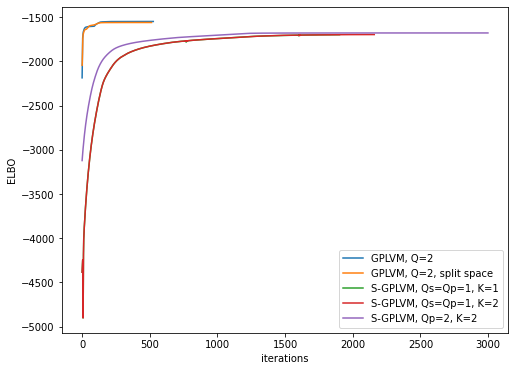

In [33]:
plt.figure(figsize=(8, 6))
names = [
    'GPLVM, Q=2',
    'GPLVM, Q=2, split space',
    'S-GPLVM, Qs=Qp=1, K=1',
    'S-GPLVM, Qs=Qp=1, K=2',
    'S-GPLVM, Qp=2, K=2'
]
elbos = [elbo1, elbo2, elbo3, elbo4, elbo5]
for i, elbo in enumerate(elbos):
    plt.plot(elbo, label=names[i])
plt.xlabel('iterations')
plt.ylabel('ELBO')
plt.legend()

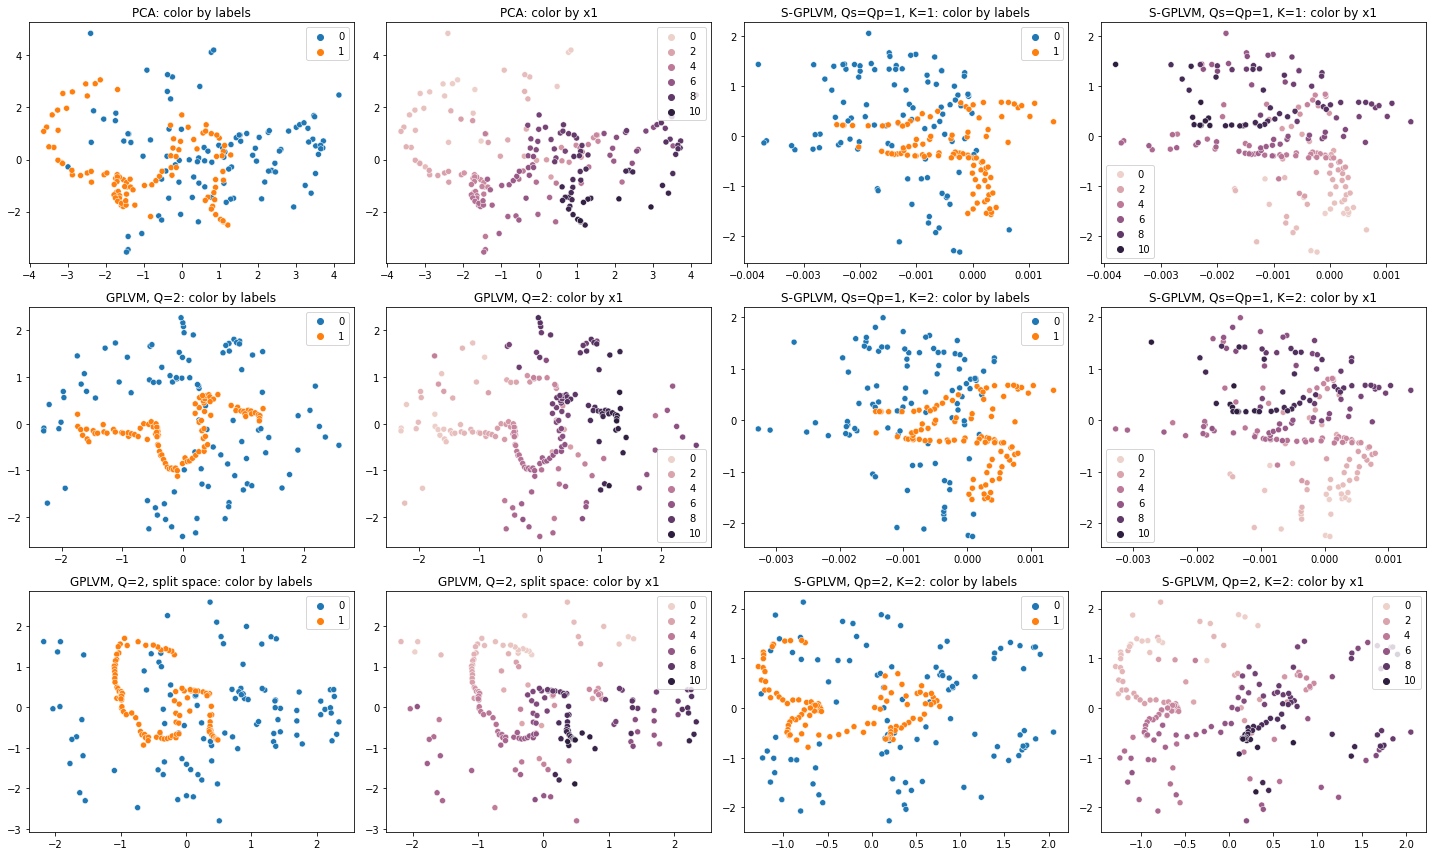

In [38]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:, 1], hue=labels, ax=axs[0, 0])
sns.scatterplot(x=X_pca[:,0], y=X_pca[:, 1], hue=X[:, 0], ax=axs[0, 1])
axs[0, 0].set_title('PCA: color by labels')
axs[0, 1].set_title('PCA: color by x1')

gplvms = [m1, m2]
for i, m in enumerate(gplvms):
    sns.scatterplot(x=m.X_data_mean.numpy()[:,0], y=m.X_data_mean.numpy()[:,1], hue=labels, ax=axs[1+i, 0])
    sns.scatterplot(x=m.X_data_mean.numpy()[:,0], y=m.X_data_mean.numpy()[:,1], hue=X[:,0], ax=axs[1+i, 1])
    axs[1+i, 0].set_title('{}: color by labels'.format(names[i]))
    axs[1+i, 1].set_title('{}: color by x1'.format(names[i]))

    
sgplvms = [m3, m4, m5]
for i, m in enumerate(sgplvms):
    if i < 2:
        sns.scatterplot(x=m.Xs_mean.numpy().flatten(), y=m.Xp_mean.numpy().flatten(), hue=labels, ax=axs[i, 2])
        sns.scatterplot(x=m.Xs_mean.numpy().flatten(), y=m.Xp_mean.numpy().flatten(), hue=X[:,0], ax=axs[i, 3])
    else:
        sns.scatterplot(x=m.Xp_mean.numpy()[:, 0], y=m.Xp_mean.numpy()[:, 1], hue=labels, ax=axs[i, 2])
        sns.scatterplot(x=m.Xp_mean.numpy()[:, 0], y=m.Xp_mean.numpy()[:, 1], hue=X[:, 0], ax=axs[i, 3])
    axs[i, 2].set_title('{}: color by labels'.format(names[2+i]))
    axs[i, 3].set_title('{}: color by x1'.format(names[2+i]))

plt.tight_layout()

In [39]:
m1

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,True,(),float64,3.060181267851915
BayesianGPLVM.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.86060271 2.07052909]
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.2076176962741391
BayesianGPLVM.X_data_mean,Parameter,,,True,"(200, 2)",float64,"[[-9.14697420e-01, 1.42285828e+00..."
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(200, 2)",float64,"[[0.00781145, 0.0263526..."
BayesianGPLVM.inducing_variable.Z,Parameter,,,True,"(20, 2)",float64,"[[2.04736065e+00, 6.14055228e-01..."


In [40]:
m2

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.4621470303763153
BayesianGPLVM.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.515175]
BayesianGPLVM.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.4857971726553214
BayesianGPLVM.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.86491886]
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.18526143583127513
BayesianGPLVM.X_data_mean,Parameter,,,True,"(200, 2)",float64,"[[-1.96458982, 1.35865629..."
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(200, 2)",float64,"[[0.01255447, 0.01875089..."
BayesianGPLVM.inducing_variable.Z,Parameter,,,True,"(20, 2)",float64,"[[5.44576728, 1.38157829..."


In [41]:
m3

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.1779549941154137
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,True,(),float64,0.022306282749485457
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.909348]
SplitGPLVM.Xp_mean,Parameter,,,True,"(200, 1)",float64,[[-0.85797739...
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(200, 1)",float64,[[0.26997208...
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 1)",float64,[[1....
SplitGPLVM.Zp.Z,Parameter,,,True,"(20, 1)",float64,[[3.49999499...
SplitGPLVM.q_mu,Parameter,,,False,"(20, 5)",float64,"[[0.088056, -0.0466274, 0.05502412..."
SplitGPLVM.q_sqrt,Parameter,FillTriangular,,False,"(5, 20, 20)",float64,"[[[9.22536384e-01, 0.00000000e+00, 0.00000000e+00..."
SplitGPLVM.kernel_s.variance,Parameter,Softplus,,True,(),float64,0.02998246279902391


In [42]:
m4

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.1276203215755343
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,True,(),float64,0.021744567960000648
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.82208878]
SplitGPLVM.kernel_K[1].variance,Parameter,Softplus,,True,(),float64,0.021744567757556944
SplitGPLVM.kernel_K[1].lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.82208795]
SplitGPLVM.Xp_mean,Parameter,,,True,"(200, 1)",float64,[[-8.78926395e-01...
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(200, 1)",float64,[[0.24200473...
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 2)",float64,"[[0.50000844, 0.49999156..."
SplitGPLVM.Zp.Z,Parameter,,,True,"(20, 1)",float64,[[3.02253235...
SplitGPLVM.q_mu,Parameter,,,False,"(20, 5)",float64,"[[5.76130754e-02, -1.06617062e-01, 1.77781952e-02..."


In [43]:
m5

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.7697637783609651
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,True,(),float64,0.032198855427239055
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1.78101534 1.2551046 ]
SplitGPLVM.kernel_K[1].variance,Parameter,Softplus,,True,(),float64,0.03219885544826978
SplitGPLVM.kernel_K[1].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1.78101602 1.25511032]
SplitGPLVM.Xp_mean,Parameter,,,True,"(200, 2)",float64,"[[-2.50039712e-01, 9.52733444e-01..."
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(200, 2)",float64,"[[0.18396752, 0.19468211..."
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 2)",float64,"[[0.49993421, 0.50006579..."
SplitGPLVM.Zp.Z,Parameter,,,True,"(20, 2)",float64,"[[6.98904832, 5.9738554..."
SplitGPLVM.q_mu,Parameter,,,False,"(20, 5)",float64,"[[3.87498779e-03, -1.66146257e-03, -1.60837662e-04..."
